In [70]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [71]:
headers = {
  'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'
}

Wyłuskanie interesujących z punktu analizy kolumn

In [72]:
def get_number_of_pages(league,year):
    page = f"https://www.transfermarkt.pl/championship/toptransfers/wettbewerb/{league}/saison_id/{year}/land_id/alle/ausrichtung//spielerposition_id/alle/altersklasse//w_s//zuab/zu/art//plus/1/galerie/0/page/1"
    treeSoup = requests.get(page, headers=headers)
    pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
    size = pageSoup.find_all("li", {"class": "tm-pagination__list-item tm-pagination__list-item--icon-last-page"})
    size = str(size).split("(strona ")[1].split(")")[0]
    return(int(size))    


Funkcja sprawadzajaca czy tag jest zgodny z wymaganiami

In [73]:
def check_club(tag):
    is_valid = False
    if tag.has_attr('class') and 'tiny_wappen' in tag.attrs['class']:
        is_valid = True
    elif tag.has_attr('title'):
        is_valid = tag.attrs['title'] == '\xa0'

    return is_valid


In [74]:
def scrape_data(leagues : list(), years : list()) -> tuple():
    club = [] #list of clubs which loan in
    players = [] #name of player
    values = [] #value in moment of transfer
    loan_year = []
    loan_league = []
    players_number = 0
    for year in years:
        print(year)
        for league in leagues:
            print(league)
            size = get_number_of_pages(league,year)
            for i in range(1,size+1):
                page = f"https://www.transfermarkt.pl/championship/toptransfers/wettbewerb/{league}/saison_id/{year}/land_id/alle/ausrichtung//spielerposition_id/alle/altersklasse//w_s//zuab/zu/art//plus/1/galerie/0/page/{i}"
                treeSoup = requests.get(page, headers=headers)
                pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
                players.extend(pageSoup.find_all("img", {"class" : "bilderrahmen-fixed lazy lazy"}))
                values.extend(pageSoup.find_all("td", {"class": ["rechts", "rechts bg_gruen_20"]}))
                club.extend(pageSoup.find_all(check_club))
                loan_year.extend(year for i in range(len(players)- players_number))
                loan_league.extend(league for i in range(len(players)- players_number))# może można jednym forem
                players_number = len(players)
                print(i)
    print(f"Graczy: {len(players)}, Klubów: {len(club)}, Wartości: {len(values)}")
    return (players,club,values,loan_league,loan_year)

Scrapowanie danych o obecnej wartości

In [75]:
def scrape_current_value_data(leagues: list(), years: list()) -> tuple():
    players = []
    price = []
    for year in years:
        print(year)
        for league in leagues:
            print(league)
            page = f"https://www.transfermarkt.pl/championship/transfers/wettbewerb/{league}/plus/?saison_id={year}&s_w=&leihe=3&intern=0&intern=1"
            treeSoup = requests.get(page, headers=headers)
            pageSoup = BeautifulSoup(treeSoup.content, 'html.parser')
            players.extend(pageSoup.find_all("span", {"class" : "hide-for-small"}))
            price.extend(pageSoup.find_all("td", {"class": ["rechts", "rechts bg_blau_20"]}))
    print(f"Graczy: {len(players)}, Wartości: {len(price)/2}")
    return (players,price)

Wyłuskanie wartości z wierszy

In [76]:
def get_loan_data(players, club, values,loan_league,loan_year):
    id_list = []
    players_list = []
    club_list = []
    values_list = []
    price_list = []
    for line in players:
        players_list.append(str(line).split('" class')[0].split('<img alt="')[1])
    for i in range(1,len(club)+1,2):
        club_list.append(str(club[i]).split('img alt="')[1].split('" class')[0])
    for i in range(0,len(values),2):
        values_list.append(str(values[i]).split("</td>")[0].split('">')[1])
        price_list.append(str(values[i+1]).split("</a>")[0].split('">')[2])
        id_list.append(str(values[i+1]).split('spieler/')[1].split('/transfer_id')[0])
    len(values_list)
    df = pd.DataFrame({"id" : id_list, "name" : players_list, "loaning_club" : club_list, "player_value_in_moment_of_transfer": values_list, "transfer_cost": price_list, "league": loan_league, "year": loan_year})
    loan_df = df.loc[df['transfer_cost'] == "Wypożyczenie"]
    return(loan_df)

Wyłuskanie obecnych wartości

In [94]:
def get_current_values(players,price):
    id_list = []
    players_list = []
    current_values_list = []
    price_list = []
    for line in players:
        players_list.append(str(line).split('">')[2].split('</a>')[0])
        id_list.append(str(line).split("\" title")[0].split("spieler/")[1])
    for i in range(0,len(price),2):
        current_values_list.append(str(price[i]).split("</td>")[0].split('">')[1])
        price_list.append(str(price[i+1]).split('">')[2].split('<')[0])
    df = pd.DataFrame({"id" : id_list, "market_value_in_eur" : current_values_list, "transfer_cost": price_list})
    loan_df = df.loc[df['transfer_cost'] == "Wypożyczenie"]
    loan_df = loan_df.iloc[:,0:2]
    return loan_df

Creating Data Frame to analyze with current values

In [78]:
def parse_value(val):
    if val == '-':
        val = 0
    else:
        vals = val.split(" ")
        if vals[1] == 'mln':
            val = int(vals[0].split(',')[0]) * 1000000
        elif vals[1] == 'tys.':
            val = int(vals[0]) * 1000
    return val

In [95]:
# Teścisko
from pathlib import Path
#loan_test = get_loan_data(*scrape_data(["GB2","GB3","GB4"],["2022","2021","2020","2019","2018"]))
val_test = get_current_values(*scrape_current_value_data(["GB2","GB3","GB4"],["2022","2021","2020","2019","2018"]))
final_test = pd.merge(loan_test,val_test, on="id").drop_duplicates(keep='first')
final_test['player_value_in_moment_of_transfer'] = final_test['player_value_in_moment_of_transfer'].apply(parse_value)
final_test['market_value_in_eur'] = final_test['market_value_in_eur'].apply(parse_value)
final_test['delta_value'] = final_test.apply(lambda x: x['market_value_in_eur'] - x['player_value_in_moment_of_transfer'], axis=1)
final_test.to_csv("data.csv",index=False)

2022
GB2
GB3
GB4
2021
GB2
GB3
GB4
2020
GB2
GB3
GB4
2019
GB2
GB3
GB4
2018
GB2
GB3
GB4
Graczy: 15153, Wartości: 15153.0


In [98]:
data = final_test.drop(columns=['id','transfer_cost'])

Analyze

In [145]:
#Most valuable player
max = data.query('market_value_in_eur == market_value_in_eur.max()')
print(f'Most valuable player to be loaned: {max.iloc[0,0]}, with value of {max.iloc[0,6]:,} euros\n')

#Biggest increase in value
biggest_increase = data.query('delta_value == delta_value.max()')
print(f'Biggest increase in value is {biggest_increase.iloc[0,0]}, whose was loaned by {biggest_increase.iloc[0,1]}, in {biggest_increase.iloc[0,4]}, at value of {biggest_increase.iloc[0,2]:,} euros, now his value is {biggest_increase.iloc[0,5]:,} euros\n')

#biggest value decrease
biggest_decrease = data.query('delta_value == delta_value.min()')
print(f'Biggest value decrease is {biggest_decrease.iloc[0,0]}, whose was loaned by {biggest_decrease.iloc[0,1]}, in {biggest_decrease.iloc[0,4]}, at value of {biggest_decrease.iloc[0,2]:,} euros, now his value is {biggest_decrease.iloc[0,5]:,} euros')

Most valuable player to be loaned: Reece James, with value of 70,000,000 euros

Biggest increase in value is Reece James, whose was loaned by Wigan Athletic, in 2018, at value of 0 euros, now his value is 70,000,000 euros

Biggest value decrease is Yannick Bolasie, whose was loaned by Aston Villa, in 2018, at value of 18,000,000 euros, now his value is 250,000 euros


In [152]:
#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot: >

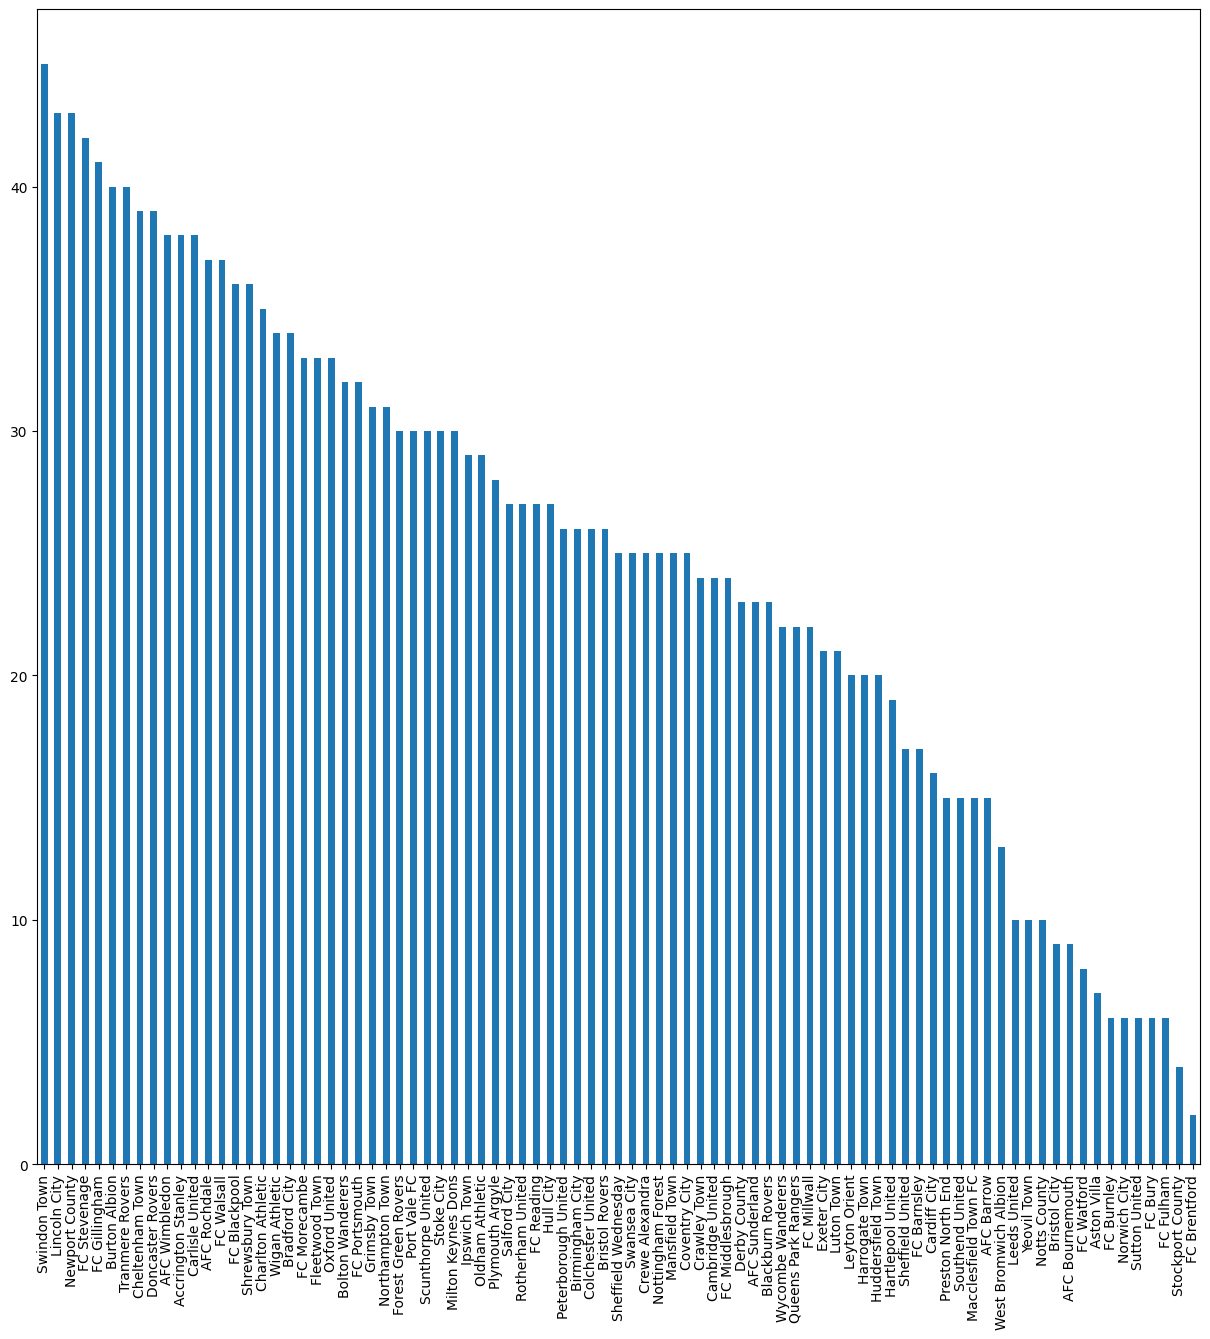

In [203]:
#Number of loans by every club
plt.figure(figsize=(15,15))
loans_number = data['loaning_club'].value_counts()
loans_number.plot(kind='bar')

<AxesSubplot: xlabel='loaning_club'>

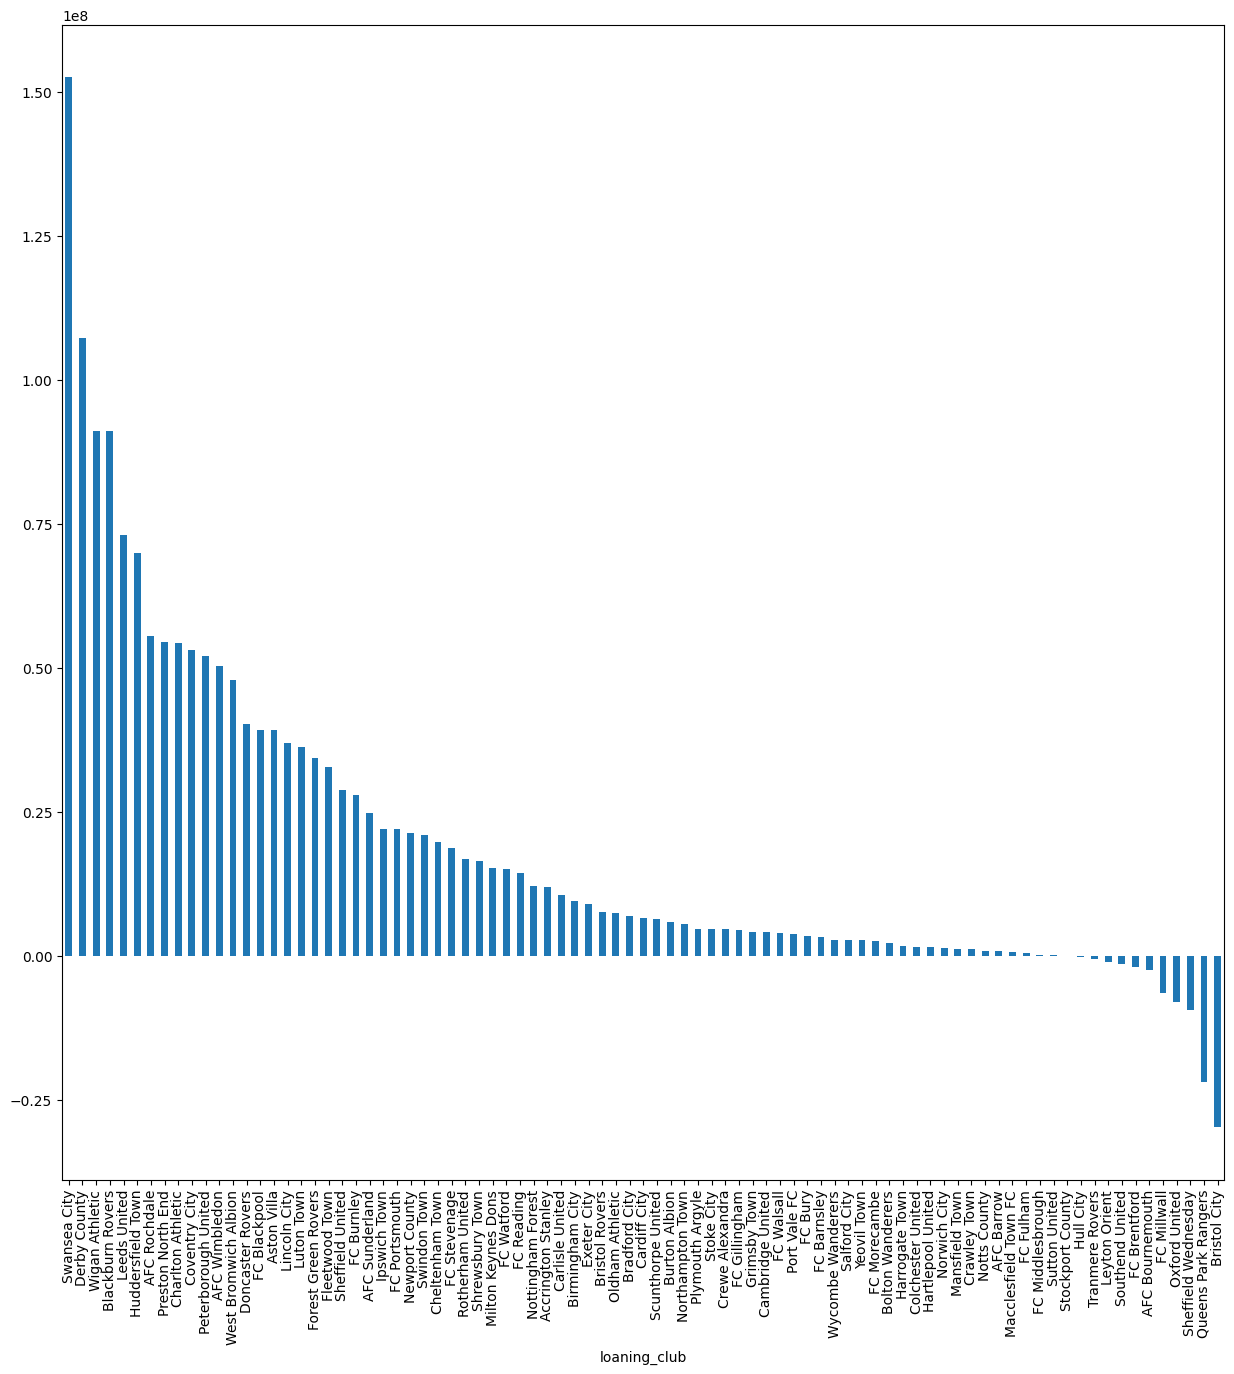

In [201]:
#Calculating which club loaned most valuable players
most_valuable = data.groupby(['loaning_club'])['delta_value'].sum()
plt.figure(figsize=(15,15))
most_valuable.sort_values(ascending= False).plot(kind='bar')

In [227]:
ddata = loans_number.to_frame().join(most_valuable)
ddata = ddata.rename(columns={'loaning_club' : 'number_of_loaned_players', 'delta_value' : 'delta_value_of_sum'})
ddata['delta_value_per_loan'] = ddata.apply(lambda x : x['delta_value_of_sum'] / x['number_of_loaned_players'], axis=1)
ddata = ddata.sort_values('delta_value_of_sum', ascending=False)

ddata['delta_value_of_sum'] = ddata.apply(lambda x: "{:,}".format(x['delta_value_of_sum']), axis=1)
pd.options.display.float_format = '{:,.2f}'.format

ddata

,number_of_loaned_players,delta_value_of_sum,delta_value_per_loan
Swansea City,25,"152,600,000.0","6,104,000.00"
Derby County,23,"107,250,000.0","4,663,043.48"
Wigan Athletic,34,"91,150,000.0","2,680,882.35"
Blackburn Rovers,23,"91,050,000.0","3,958,695.65"
Leeds United,10,"73,150,000.0","7,315,000.00"
...,...,...,...
FC Millwall,22,"-6,550,000.0","-297,727.27"
Oxford United,33,"-8,050,000.0","-243,939.39"
Sheffield Wednesday,25,"-9,450,000.0","-378,000.00"
Queens Park Rangers,22,"-21,900,000.0","-995,454.55"
